# Analysis of the S1S2-water and Danish datasets
In this notebook, I perform an analysis of the two datasets that I use in this project. I check what kind of RGB values the two datasets have, to determine whether they have similar colors or not. This helps to decide whether the datasets are compatible with the same model or not.

### Analysis of unprocessed S1S2-water data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import json
import random
from tqdm import tqdm
import torch

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('./UNet_code')
from data_loader import CustomDataLoader
from torch.utils.data import DataLoader

# Open a random file from the S1S2 dataset (before pre-processing!) to see the RGB values
path = './S1S2-Water/data/1'
files = os.listdir(path)
img_files = [f for f in files if 'img' in f]
img_path = os.path.join(path, img_files[0])
img_data = rasterio.open(img_path)

img = img_data.read()
b, g, r, nir, swir1, swir2 = img

In [2]:
# We find that the values have quite a high range, presumably 0...65535 (2^16)
for channel in img: 
    print(np.max(channel), np.min(channel))

18294 1
18991 1
21077 1
22748 169
15270 38
14266 1


# Analysis of the RGB values of the Danish data and the S1S2-water dataset

In [3]:
os.makedirs('images', exist_ok = True)
channels = 'r.g.b'

# Danish data
data_path = './denmark_data'
image_path = data_path + '/{}/img/*'
mask_path = data_path + '/{}/msk/*'

test_dataset = CustomDataLoader(image_path.format('test'), mask_path.format('test'), channels = channels)
test_loader = DataLoader(dataset = test_dataset, batch_size = 8, shuffle = False, num_workers = 8)

# S1S2 
data_path = './data_prepped'
image_path = data_path + '/{}/img/*'
mask_path = data_path + '/{}/msk/*'

s1s2_test_dataset = CustomDataLoader(image_path.format('test'), mask_path.format('test'), channels = channels)
s1s2_test_loader = DataLoader(dataset = s1s2_test_dataset, batch_size = 8, shuffle = False, num_workers = 8)

### S1S2-water data

In [4]:
s1s2_data = {'r': [], 'g': [], 'b': []}

for batch in tqdm(s1s2_test_loader):
    img, label = batch
    img = img.to(torch.float16).cpu().numpy()
    img = img.reshape(3, -1)
    for i, channel in enumerate(s1s2_data):
        s1s2_data[channel].extend(np.random.choice(img[i, :], int(img.shape[-1]/100), replace = False))
    # s1s2_data.extend()

100%|███████████████████████████████████████████████████████████████████████████████| 3211/3211 [23:31<00:00,  2.28it/s]


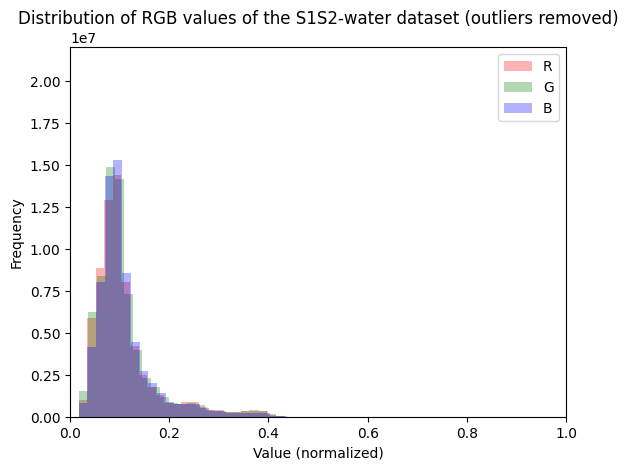

CPU times: user 8min 14s, sys: 1min 2s, total: 9min 16s
Wall time: 15min


In [5]:
%%time
import matplotlib.pyplot as plt
plt.hist(s1s2_data['r'], bins = 100, color = 'r', label = 'R', alpha = 0.3)
plt.hist(s1s2_data['g'], bins = 100, color = 'g', label = 'G', alpha = 0.3)
plt.hist(s1s2_data['b'], bins = 100, color = 'b', label = 'B', alpha = 0.3)
plt.xlim(0, 1)
plt.ylim(0, 2.2e7)
plt.ylabel('Frequency')
plt.xlabel('Value (normalized)')
plt.title('Distribution of RGB values of the S1S2-water dataset (outliers removed)')
plt.legend()
plt.savefig(f'./images/s1s2_water_RGB.png', bbox_inches='tight', transparent=True)
plt.show()

del s1s2_data # Clear up memory to process the Danish data too

### Danish data

In [6]:
import torch
torch.multiprocessing.set_sharing_strategy('file_system')
dk_data = {'r': [], 'g': [], 'b': []}

for batch in tqdm(test_loader):
    img, label = batch
    img = (img/255).to(torch.float16).cpu().numpy()
    img = img.reshape(3, -1)
    for i, channel in enumerate(dk_data):
        dk_data[channel].extend(np.random.choice(img[i, :], int(img.shape[-1]/100), replace = False))

100%|███████████████████████████████████████████████████████████████████████████████| 6896/6896 [57:54<00:00,  1.98it/s]


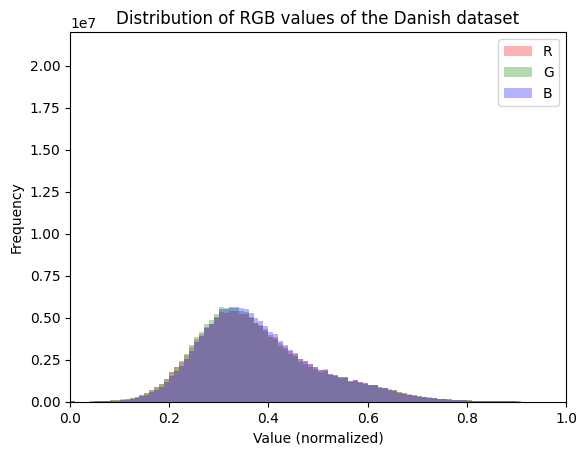

CPU times: user 17min 38s, sys: 1min 57s, total: 19min 36s
Wall time: 33min 16s


In [7]:
%%time
import matplotlib.pyplot as plt
plt.hist(dk_data['r'], bins = 100, color = 'r', label = 'R', alpha = 0.3)
plt.hist(dk_data['g'], bins = 100, color = 'g', label = 'G', alpha = 0.3)
plt.hist(dk_data['b'], bins = 100, color = 'b', label = 'B', alpha = 0.3)
plt.xlim(0,1)
plt.ylim(0, 2.2e7)
plt.ylim()
plt.ylabel('Frequency')
plt.xlabel('Value (normalized)')
plt.title('Distribution of RGB values of the Danish dataset')
plt.legend()
plt.savefig(f'./images/denmark_RGB.png', bbox_inches='tight', transparent=True)
plt.show()